In [1]:
import numpy as np
import torch
from scipy import signal
import matplotlib.pyplot as plt
from einops import rearrange

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# Use 'notebook' instead for interactive plots
%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

import seaborn as sns
sns.set(rc={
    "figure.dpi":300,
    'savefig.dpi':300,
    'animation.html':'jshtml',
    'animation.embed_limit':100, # Max animation size in Mb
})
sns.set_context('notebook')
sns.set_style('ticks') # 'whitegrid' | 'ticks'

In [2]:
def discrete_kernel_sequential(L, A, b, c=None):
    b_ = b
    x = []
    for _ in range(L):
        if c is not None:
            x_ = np.sum(c*b_, axis=-1) # (...) # could be faster with matmul or einsum?
        else:
            x_ = b_
        x.append(x_)
        b_ = (A @ b_[..., None]).squeeze(-1)

    x = np.stack(x, axis=-1)
    return x

def kernel(A, B, C, L=1000, dt=0.01):
    """ This essentially computes the impulse response corresponding to the SSM (A, B, C).
    
    It computes the vector of C * dA^k * dB where dA, dB are the discretized SSM matrices.
    This is very close to taking the function C * exp(tA) * B and sampling at a rate of dt
    (with a slight change in normalization)
    """

    B = B[:, None]
    C = C[None, :]
    D = np.zeros((1,))
    dA, dB, dC, dD, _ = signal.cont2discrete((A, B, C, D), dt=dt, method='zoh')

    dB = dB[:, 0]
    dC = dC[0, :]

    K = discrete_kernel_sequential(L, dA, dB, dC)
    return K

def transition(measure, N, **measure_args):
    """ A, B transition matrices for different measures
    measure: the type of measure
      legt - Legendre (translated)
      legs - Legendre (scaled)
      glagt - generalized Laguerre (translated)
      lagt, tlagt - previous versions of (tilted) Laguerre with slightly different normalization
    """
    # Laguerre (translated)
    if measure == 'lagt':
        b = measure_args.get('beta', 1.0)
        A = np.eye(N) / 2 - np.tril(np.ones((N, N)))
        B = b * np.ones((N, 1))
    # Legendre (translated)
    elif measure == 'legt':
        Q = np.arange(N, dtype=np.float64)
        R = (2*Q + 1) ** .5
        j, i = np.meshgrid(Q, Q)
        A = R[:, None] * np.where(i < j, (-1.)**(i-j), 1) * R[None, :]
        B = R[:, None]
        A = -A

        # Halve again for timescale correctness
        A *= 0.5
        B *= 0.5
    # Legendre (scaled)
    elif measure == 'legs':
        q = np.arange(N, dtype=np.float64)
        col, row = np.meshgrid(q, q)
        r = 2 * q + 1
        M = -(np.where(row >= col, r, 0) - np.diag(q))
        T = np.sqrt(np.diag(2 * q + 1))
        A = T @ M @ np.linalg.inv(T)
        B = np.diag(T)[:, None]
        B = B.copy() # Otherwise "UserWarning: given NumPY array is not writeable..." after torch.as_tensor(B)
    elif measure == 'legsd': # Diagonal version of LegS by chopping off low-rank
        q = np.arange(N, dtype=np.float64)
        col, row = np.meshgrid(q, q)
        r = 2 * q + 1
        M = -(np.where(row >= col, r, 0) - np.diag(q))
        T = np.sqrt(np.diag(2 * q + 1))
        A = T @ M @ np.linalg.inv(T)
        B = np.diag(T)[:, None]
        B = B.copy() # Otherwise "UserWarning: given NumPY array is not writeable..." after torch.as_tensor(B)
        A += .5 * B*B[None, :, 0]
        B = B / 2.0
    elif measure in ['fourier_diag', 'foud']:
        freqs = np.arange(N//2)
        d = np.stack([freqs, np.zeros(N//2)], axis=-1).reshape(-1)[:-1]
        A = 2*np.pi*(-np.diag(d, 1) + np.diag(d, -1))
        A = A - .5 * np.eye(N)
        B = np.zeros(N)
        B[0::2] = 2**.5
        B[0] = 1
        B = B[:, None]
    elif measure in ['fourier', 'fout']:
        freqs = np.arange(N//2)
        d = np.stack([np.zeros(N//2), freqs], axis=-1).reshape(-1)[1:]
        A = np.pi*(-np.diag(d, 1) + np.diag(d, -1))
        B = np.zeros(N)
        B[0::2] = 2**.5
        B[0] = 1

        # Subtract off rank correction - this corresponds to the other endpoint u(t-1) in this case
        A = A - B[:, None] * B[None, :]
        B = B[:, None]
        
        # Double the matrices to be supported on [0,1] for illustration purposes
        A = 2*A
        B = 2*B
    elif measure == 'random':
        A = np.random.randn(N, N) / N
        B = np.random.randn(N, 1)
    elif measure == 'diagonal':
        A = -np.diag(np.exp(np.random.randn(N)))
        B = np.random.randn(N, 1)
    else:
        raise NotImplementedError

    return A, B

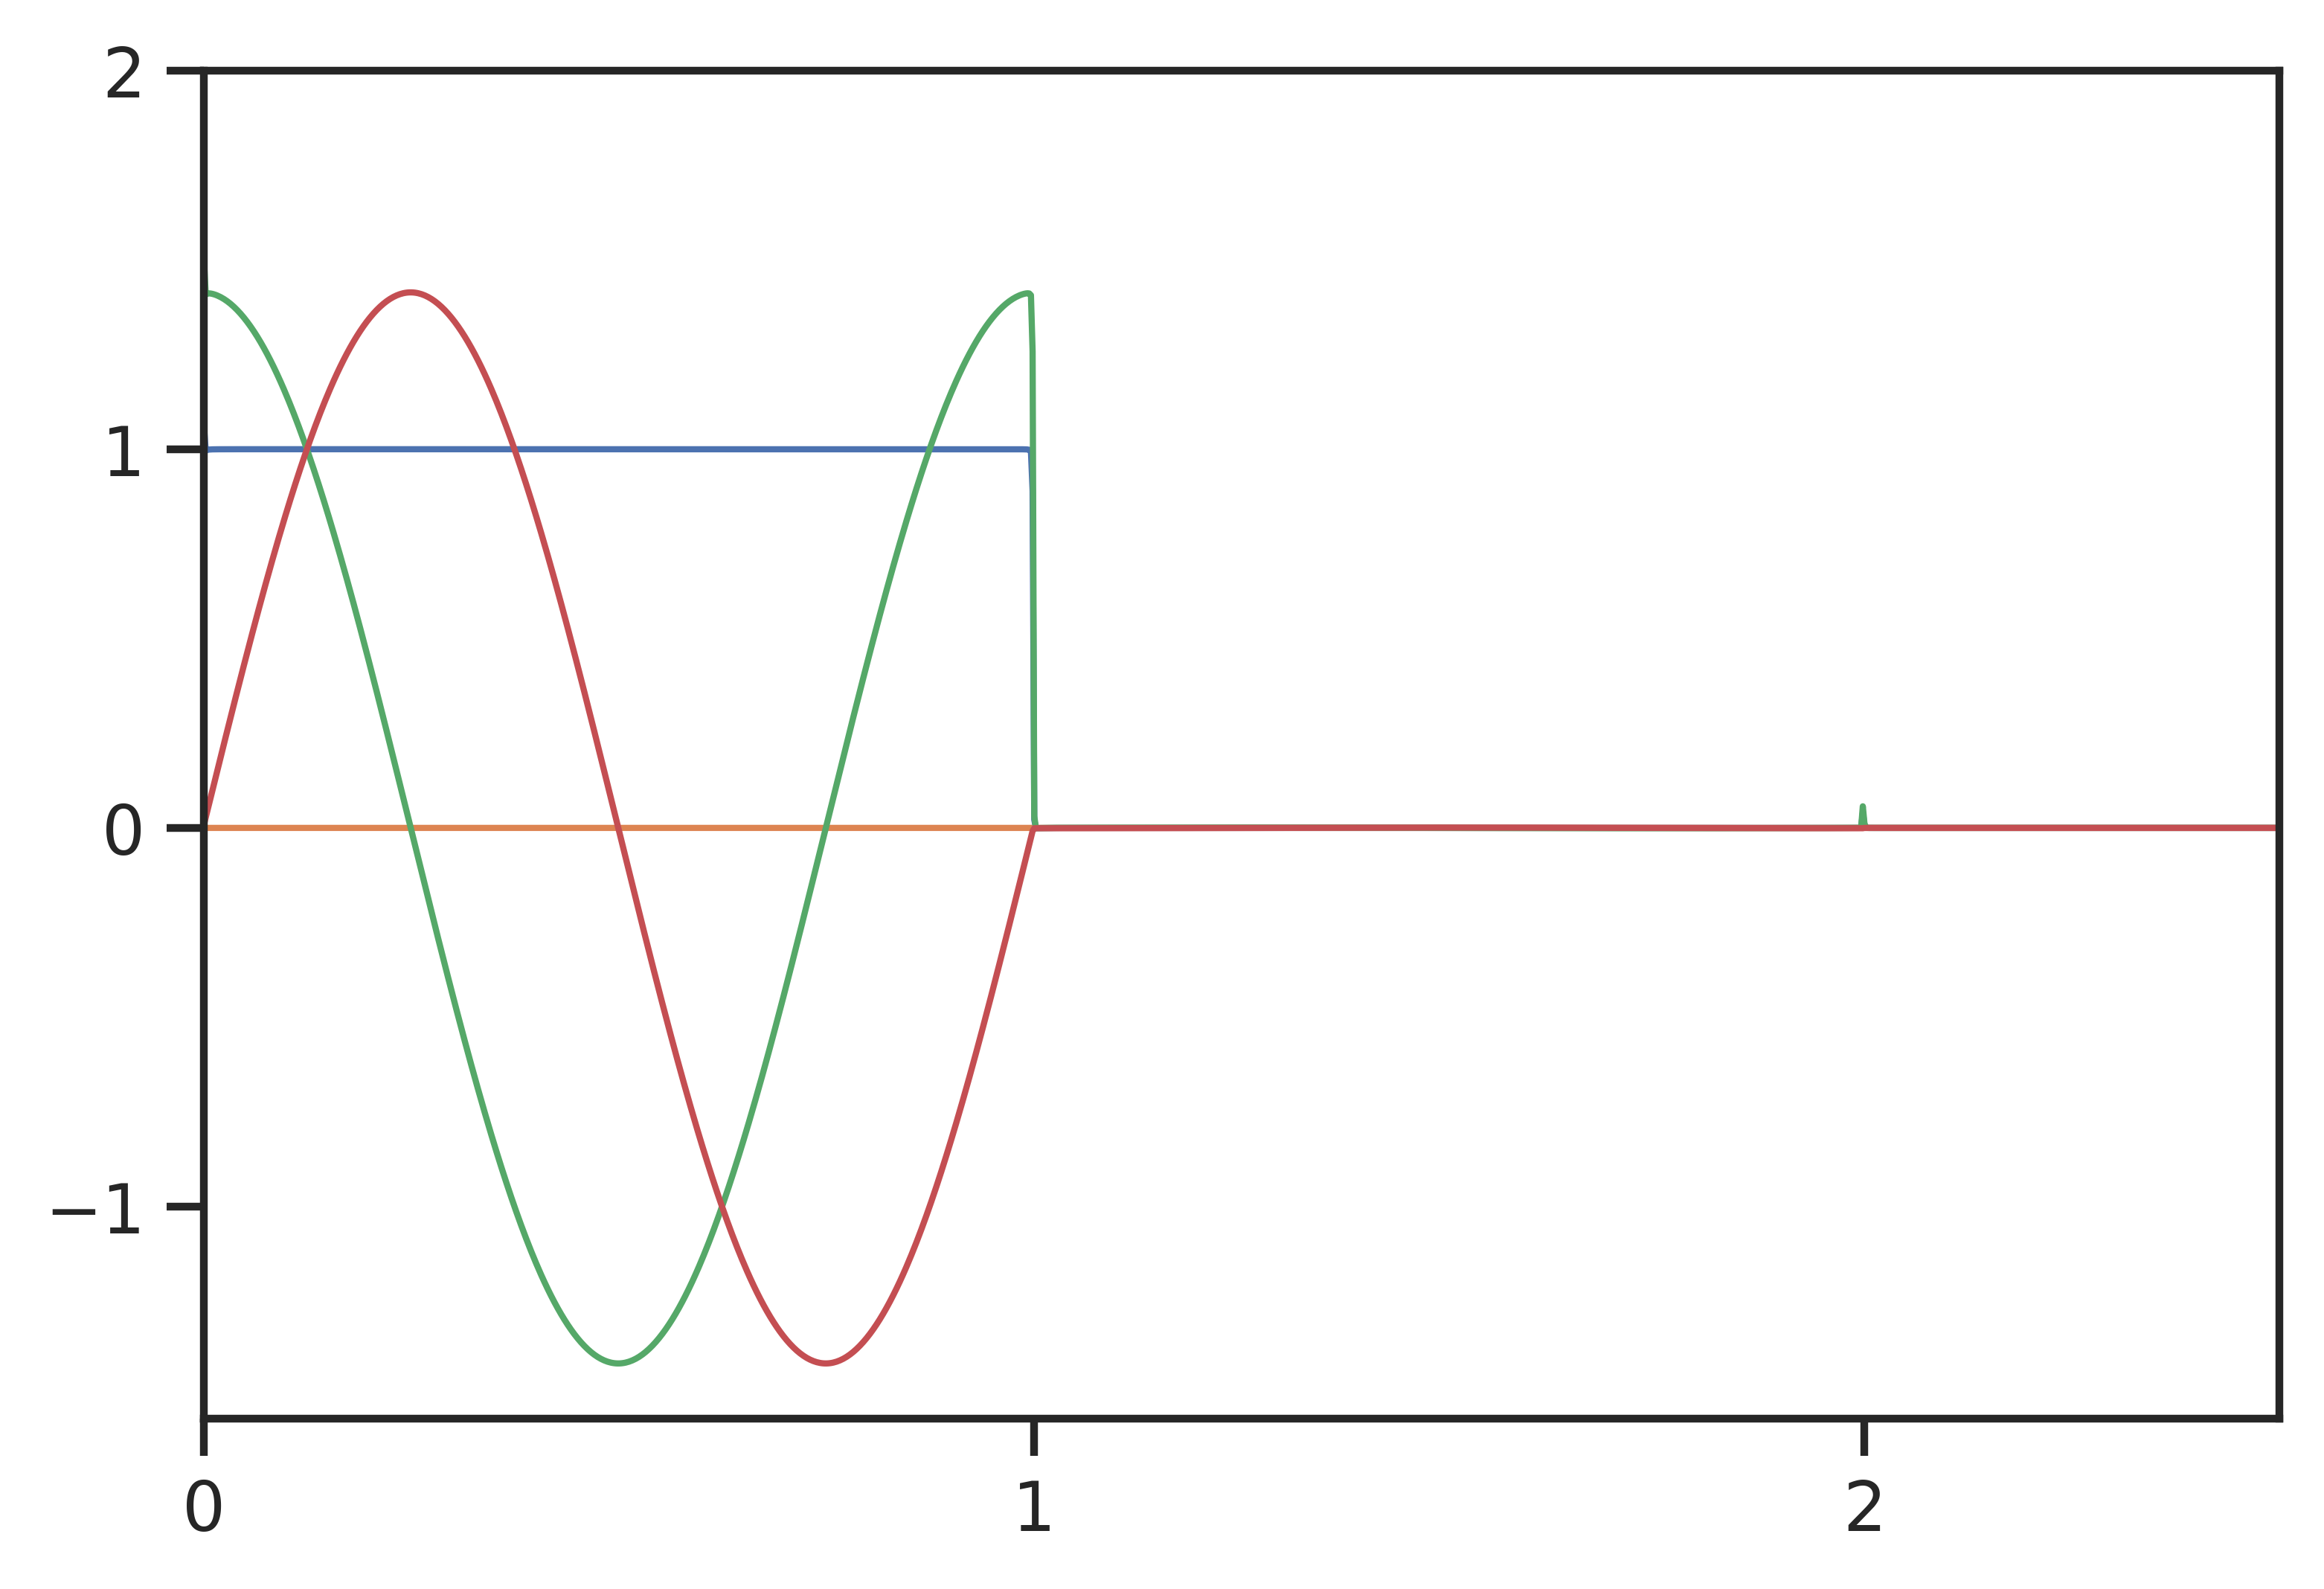

In [3]:
N = 1024
measure = 'fout'

A, B = transition(measure, N)
B = B[:, 0]
C = np.random.normal(size=N)



T = 2.5
dt = 0.002
L = round(T/dt)
x = np.arange(0, T, dt)


plt.figure()
C = np.eye(A.shape[-1])
K = kernel(A, B, C, L=L, dt=dt) / dt
for i in range(4):
    plt.plot(x, K[i], linewidth=1.0)

plt.xticks(np.arange(0, T+1e-3, 1.0))
plt.yticks([-1.0, 0.0, 1.0, 2.0])
plt.xlim(0.0, T)
# plt.legend()
plt.ioff()
plt.show()
plt.close()

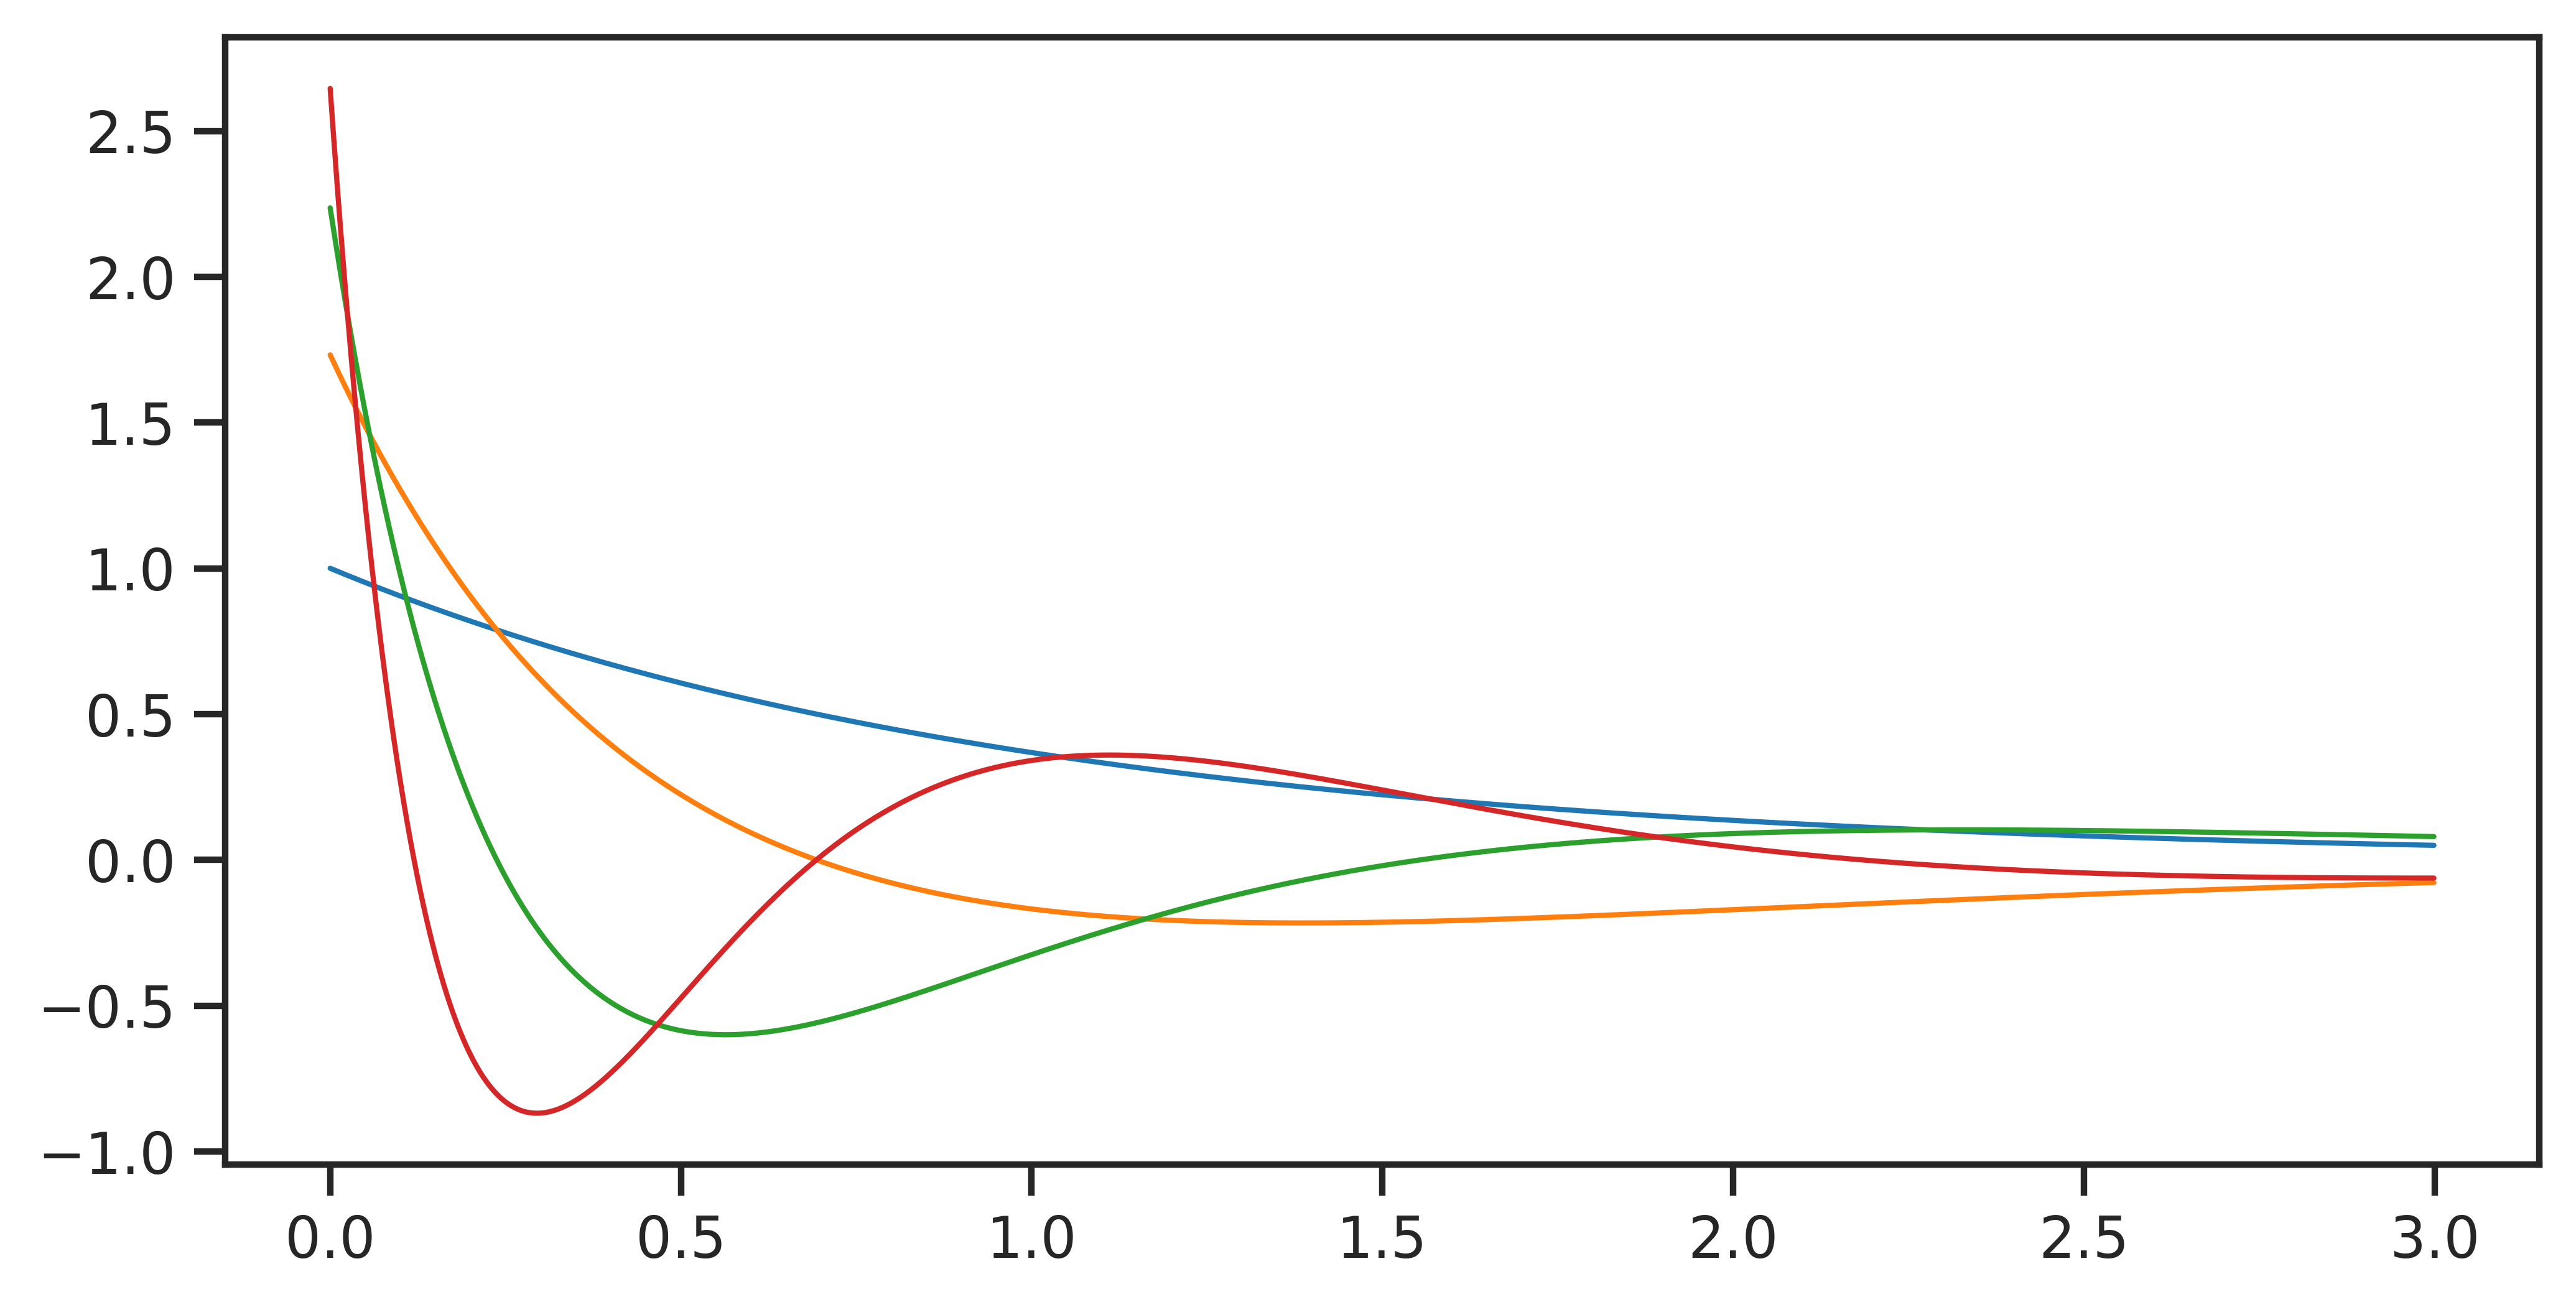

(4, 3000)
[[ 1.90137623  0.16569139 -0.18834346  0.19383211]
 [ 0.16569139  1.73291672  0.31844358 -0.31203791]
 [-0.18834346  0.31844358  1.63707597  0.37899988]
 [ 0.19383211 -0.31203791  0.37899988  1.62407964]]


In [4]:
### Legs: matches "warped Legendre" functions, orthogonal w.r.t. exponential measure

## First recreate the legS basis functions
from scipy import special as ss

plt.figure(figsize=(8, 4))
# plt.xticks([])
# plt.yticks([])

N = 4
nodes = np.arange(0, 3, .001)
eval_nodes = 2*np.exp(-nodes)-1
eval_matrix = ss.eval_legendre(np.arange(N)[:, None], eval_nodes) # (N, T)
basis = eval_matrix * np.exp(-nodes) * (1+2*np.arange(N)[:, None])**(.5)
mpl_colors = [['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][i] for i in range(N)]
for basis_fn, color in zip(basis, mpl_colors):
    plt.plot(nodes, basis_fn, color=color, linewidth=1.0)
plt.show()
    
## Show that they are orthogonal with a certain tilting
print(basis.shape)
tilt = np.exp(nodes)
gram = np.einsum('nl,l,lm->nm', basis, tilt, basis.T) * dt
print(gram[:10, :10])

([<matplotlib.axis.XTick at 0x7fbe3974a520>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

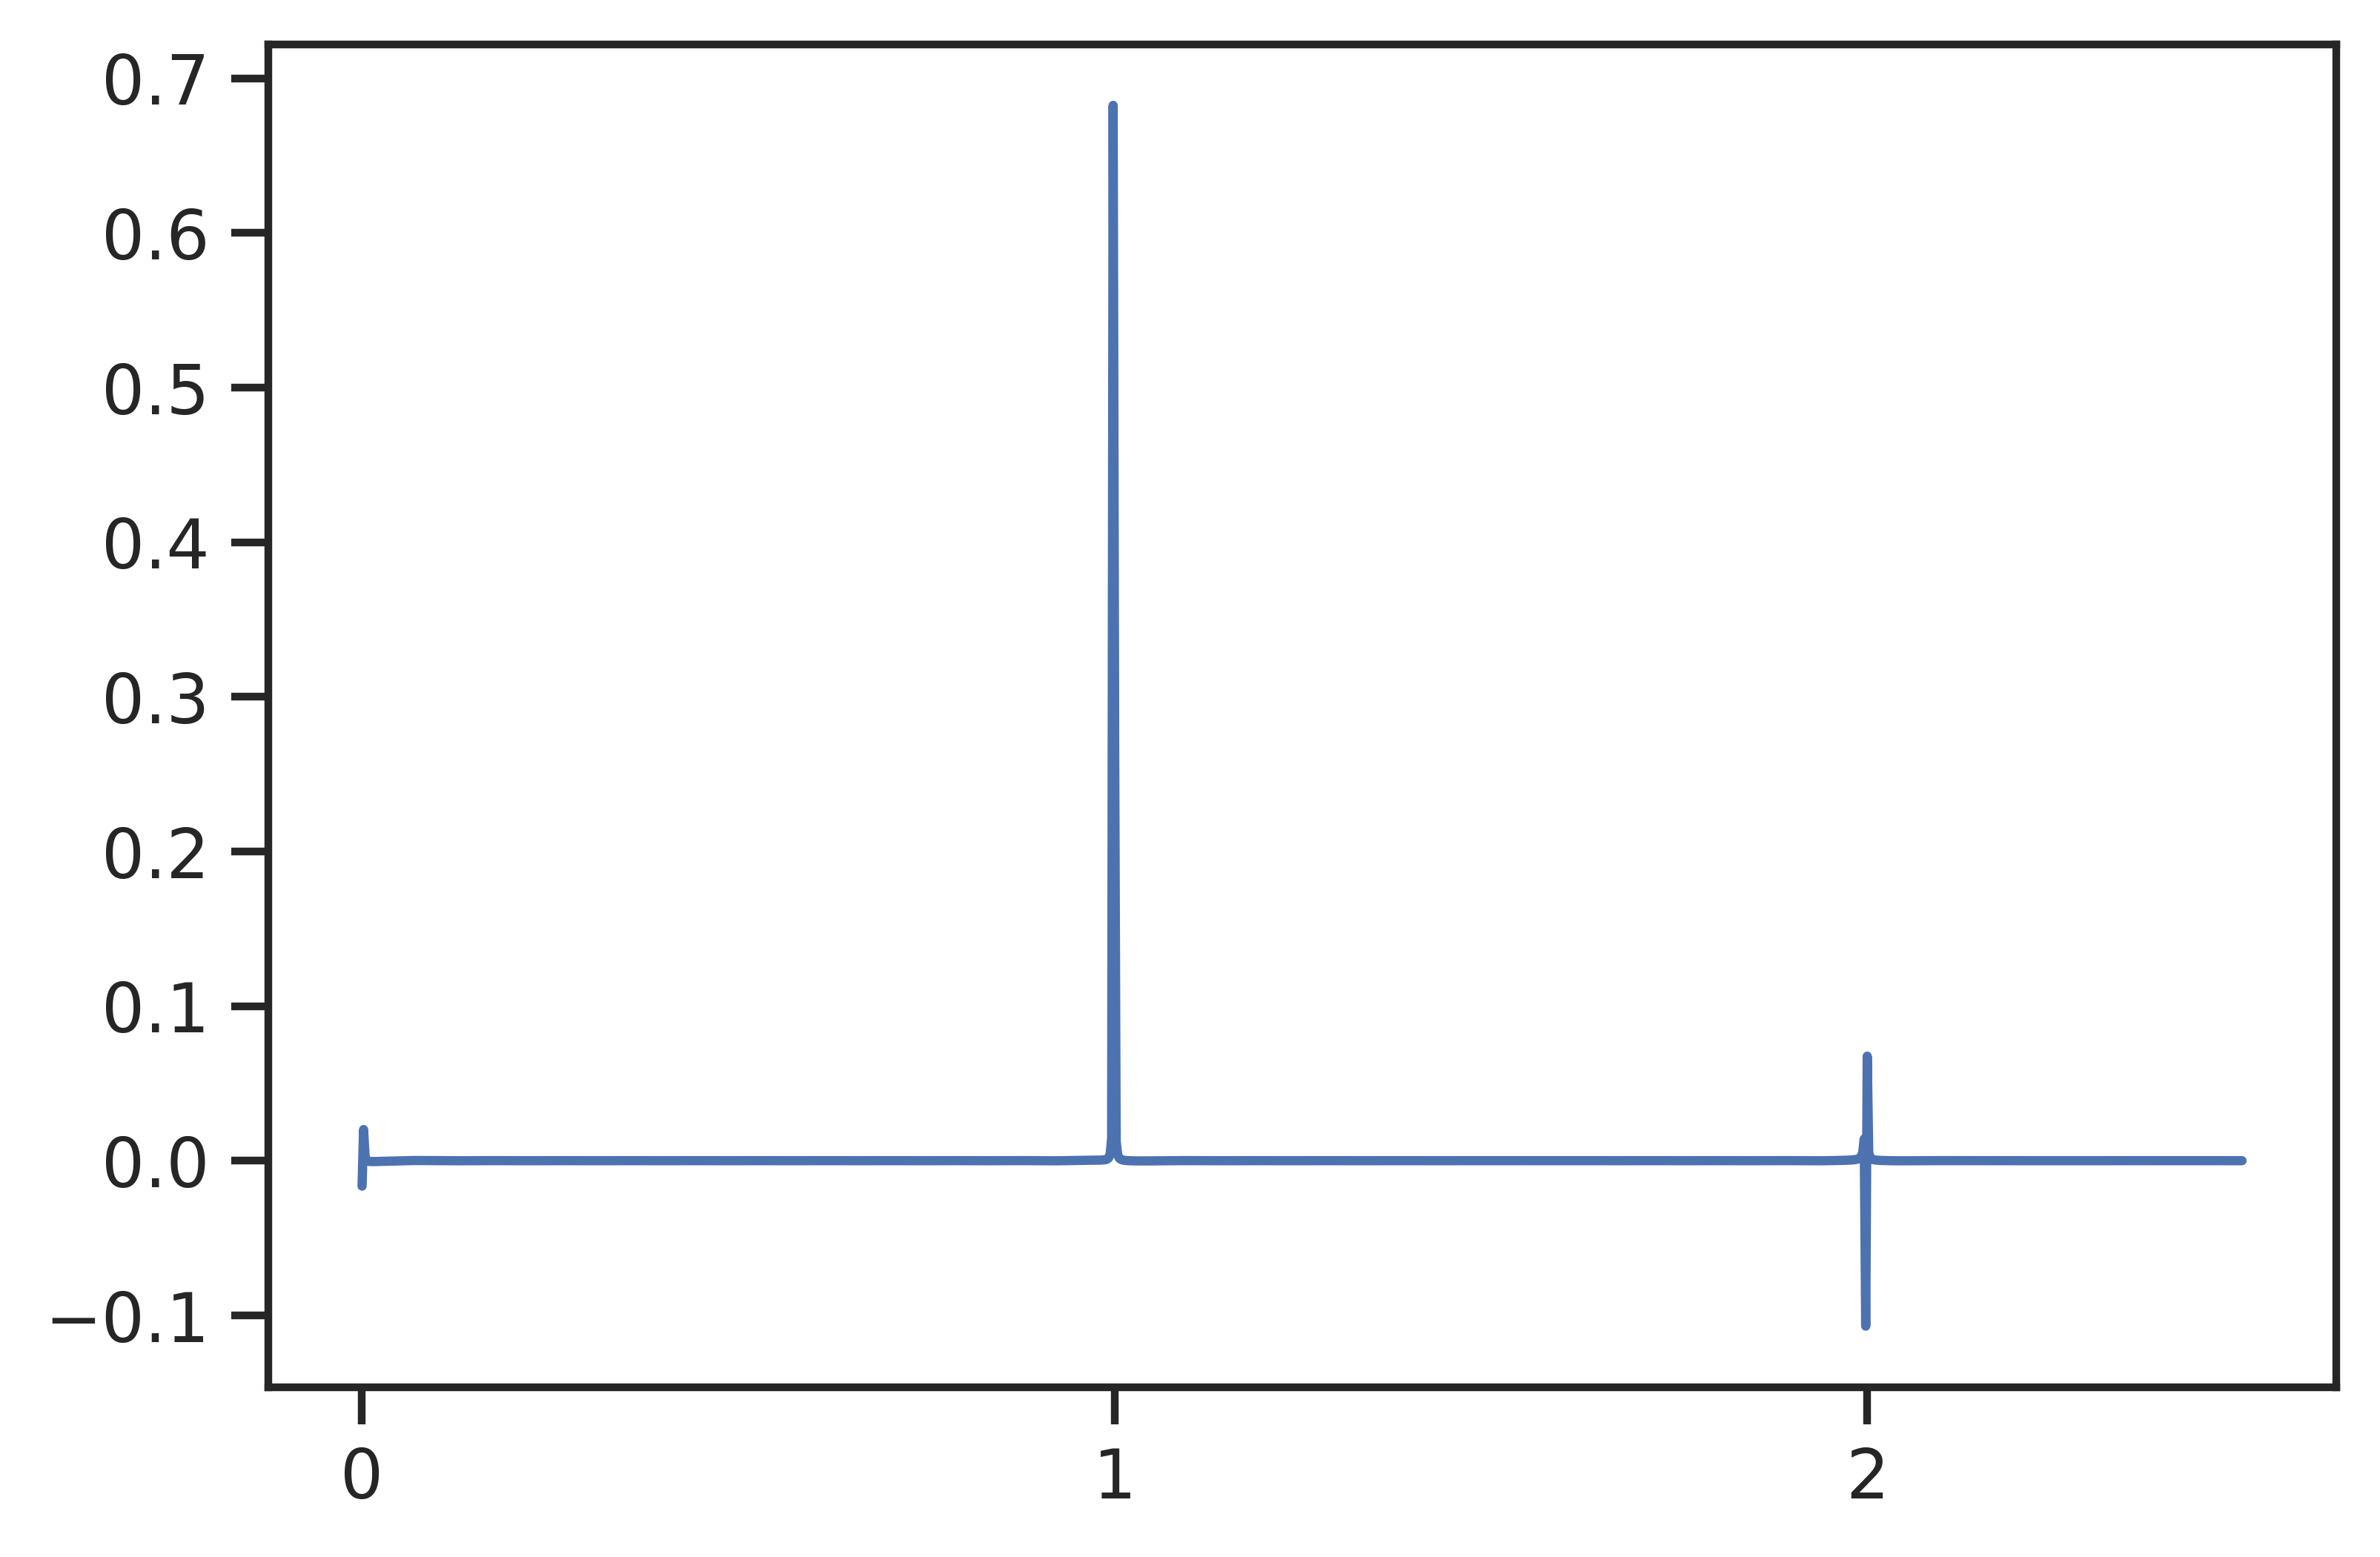

In [5]:
# Try spiking function. Note that the legt case should provide the Pade approximant of delay network
# i.e. the plot should be close to the delta(t-1) function and the Laplace transform of the plot will be Pade approximant of e^(-s))

if measure == 'legt':
    C = (np.arange(N)*2+1)**.5 * (-1)**np.arange(N)
    D = 0.
elif measure in ['fourier', 'fout']:
    C = B
    D = 1.
else: assert False
    

K = kernel(A, B, C, L=L, dt=dt)
K[0] -= D
plt.figure()
plt.plot(x, K)
plt.xticks([0.0, 1.0, 2.0])
# plt.yticks([0.0, 0.5, 1.0])


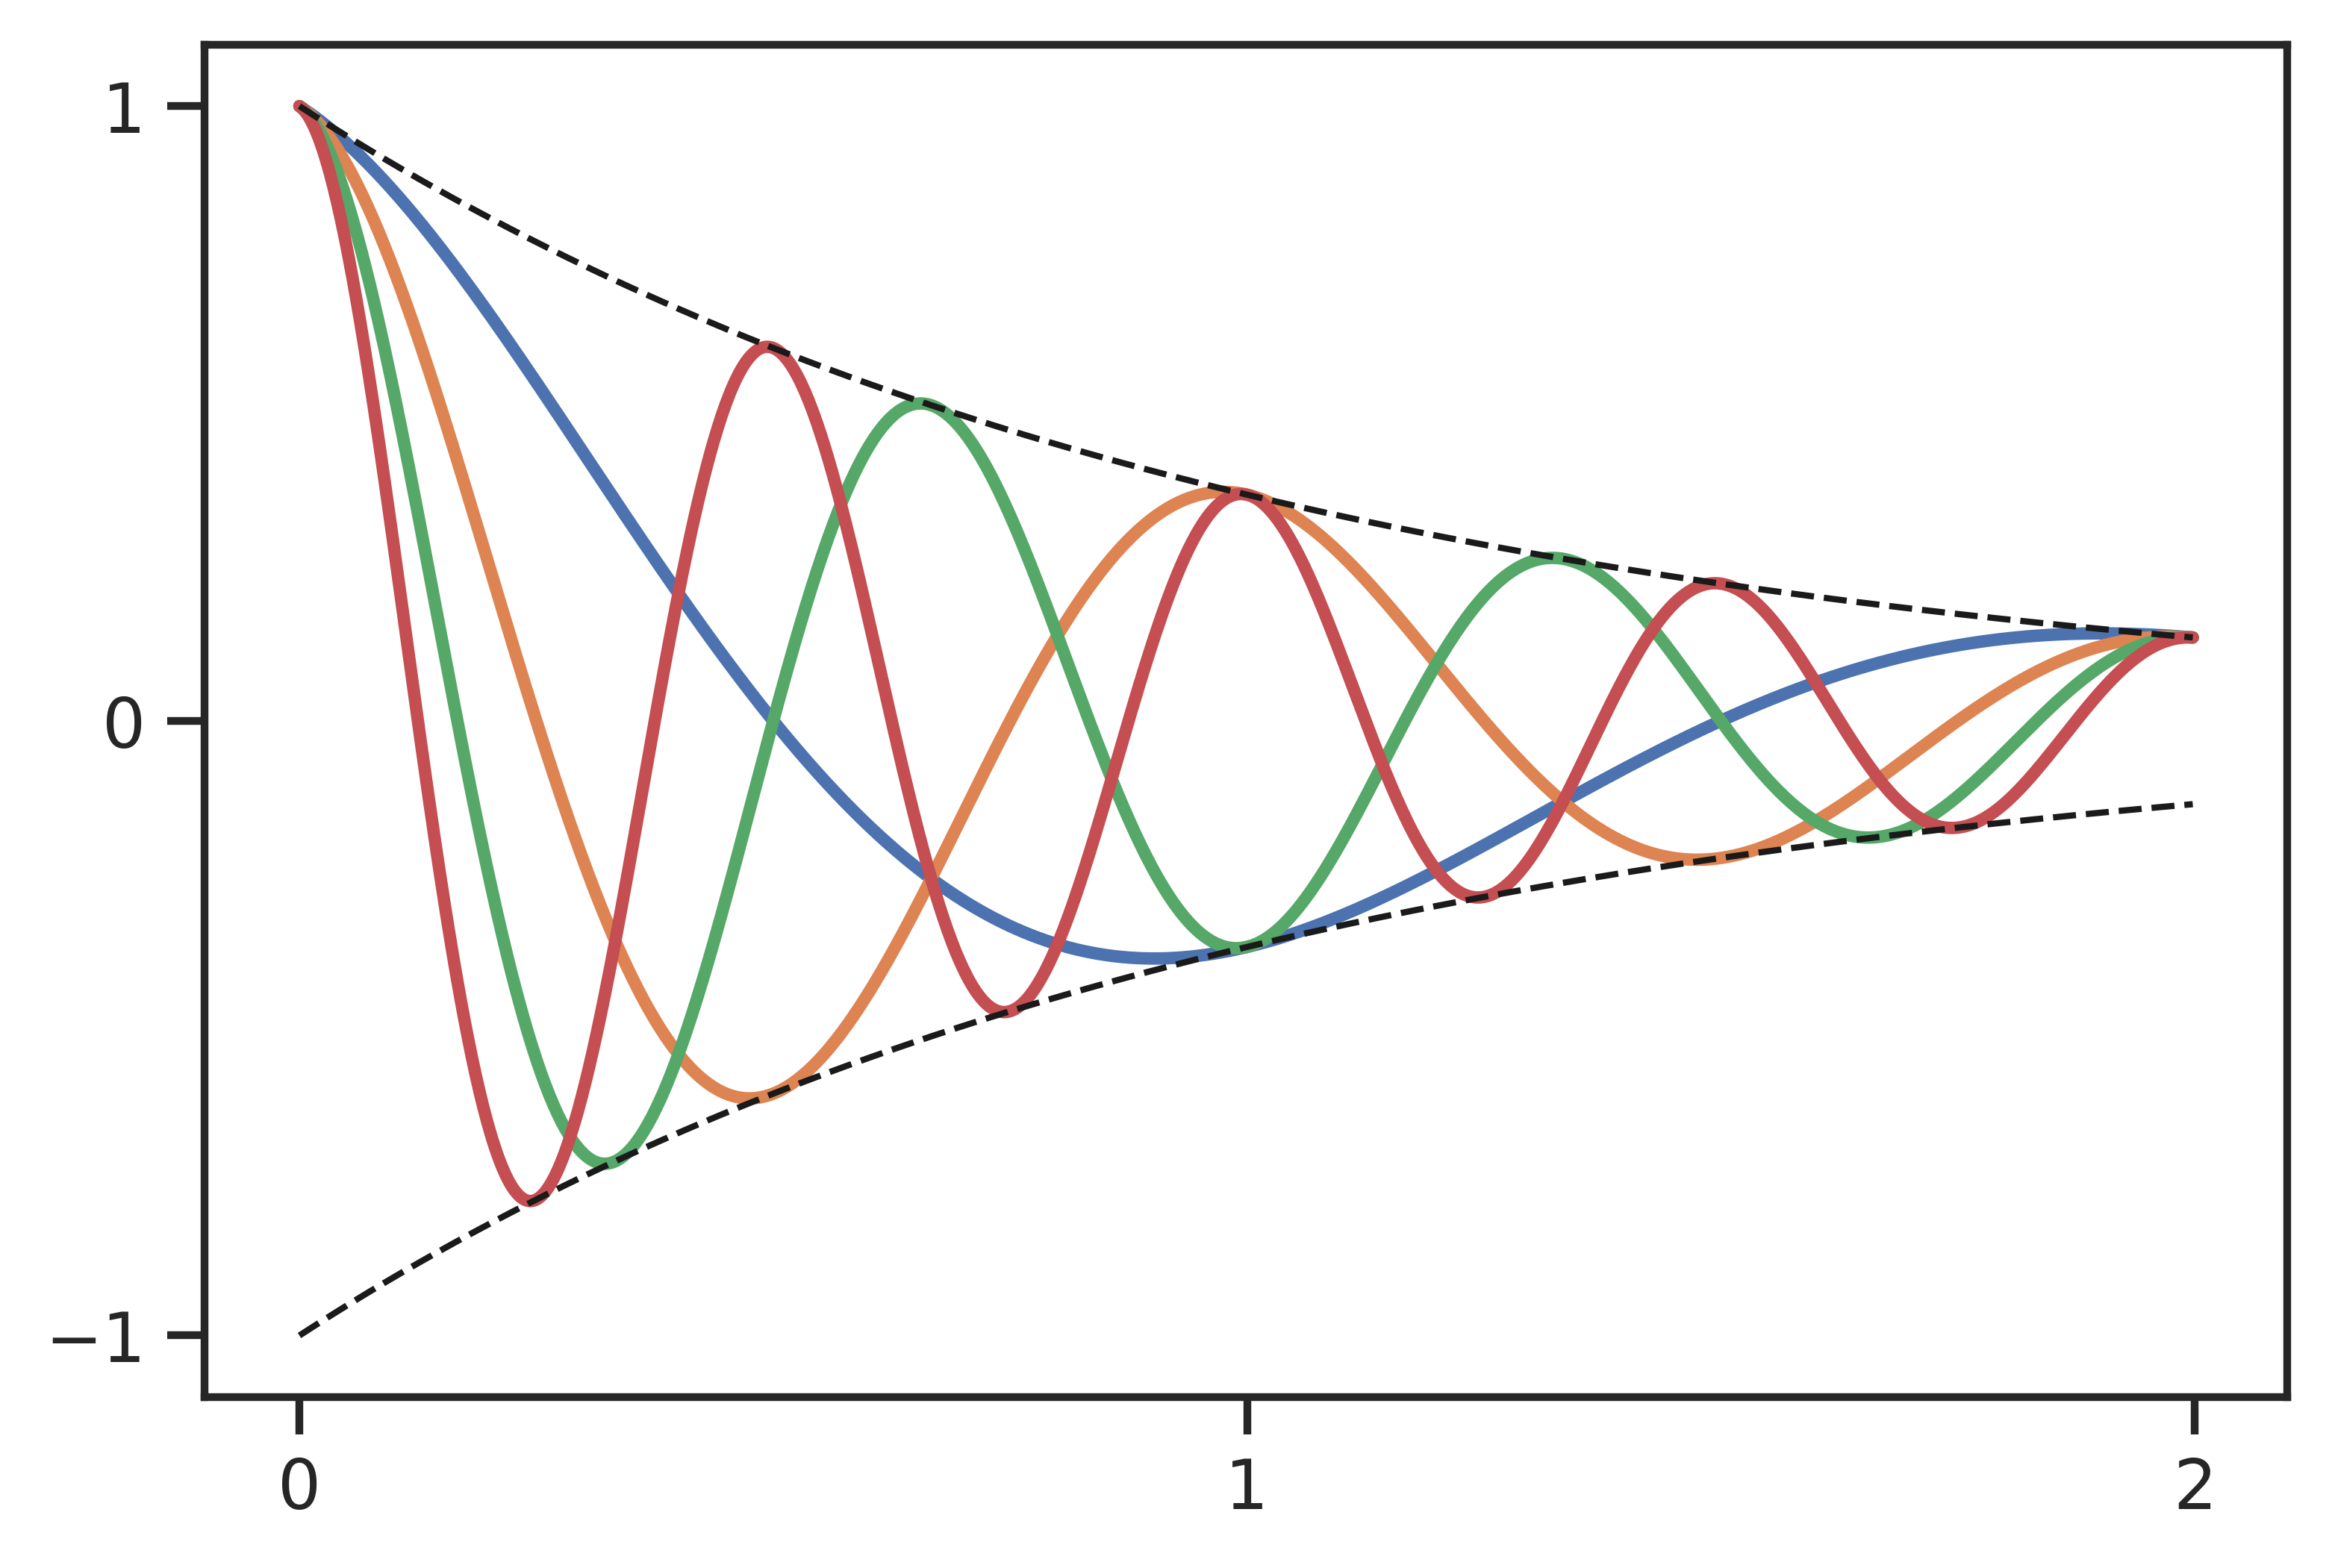

In [6]:
# Plot exp*fourier basis functions - corresponds to S4D-Lin (also called the foud measure)

plt.figure()

x = np.arange(0.0, 2.0, 0.002)

alpha = 1.0

for n in range(1, 5):
    plt.plot(x, np.cos(np.pi*n*x)*np.exp(-alpha*x), linewidth=2.0)

plt.plot(x, np.exp(-alpha*x), 'k', linewidth=1.0, linestyle='--')
plt.plot(x, -np.exp(-alpha*x), 'k', linewidth=1.0, linestyle='--')

plt.yticks([-1.0, 0.0, 1.0])
plt.xticks([0.0, 1.0, 2.0])
# plt.legend()
plt.ioff()
plt.show()
plt.close()